<a href="https://colab.research.google.com/github/susanemiliaw/NTHU_2025_DLIA_HW/blob/main/HW3_113034421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR  # we can add WarmRestarts later if needed

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 123

def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Device (GPU / CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ZIP_PATH = "/content/drive/MyDrive/IntrotoAI/114-artificial-intelligence-hw-3.zip"

In [4]:
import zipfile

EXTRACT_DIR = "/content/hw3_data"

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Extracted files to:", EXTRACT_DIR)

Extracted files to: /content/hw3_data


In [5]:
import pandas as pd
from pathlib import Path

# Paths
train_path = Path(EXTRACT_DIR) / "train.csv"
test_path  = Path(EXTRACT_DIR) / "test.csv"

# Load CSVs
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

display(train_df.head())
display(test_df.head())


Train shape: (20631, 27)
Test shape: (12680, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,189
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,187


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100,38.86,23.3735
1,1,2,-0.0027,-0.0003,100,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100,39.02,23.3916
2,1,3,0.0003,0.0001,100,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100,39.08,23.4166
3,1,4,0.0042,0.0000,100,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100,39.00,23.3737
4,1,5,0.0014,0.0000,100,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100,38.99,23.4130


## Data PREPROCESSING

Train shape : (20631, 27)
Test shape  : (12680, 26)

=== TRAIN INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  int64  
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64


None


=== Missing Values (Train) ===
id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
RUL         0
dtype: int64


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000



Columns with ALL NULL: []

Columns with NO VARIANCE: ['setting3', 's1', 's5', 's10', 's16', 's18', 's19']

Dropping banned cols: ['setting1', 'setting2', 's6', 's14']

Final usable feature columns: ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's15', 's17', 's20', 's21']


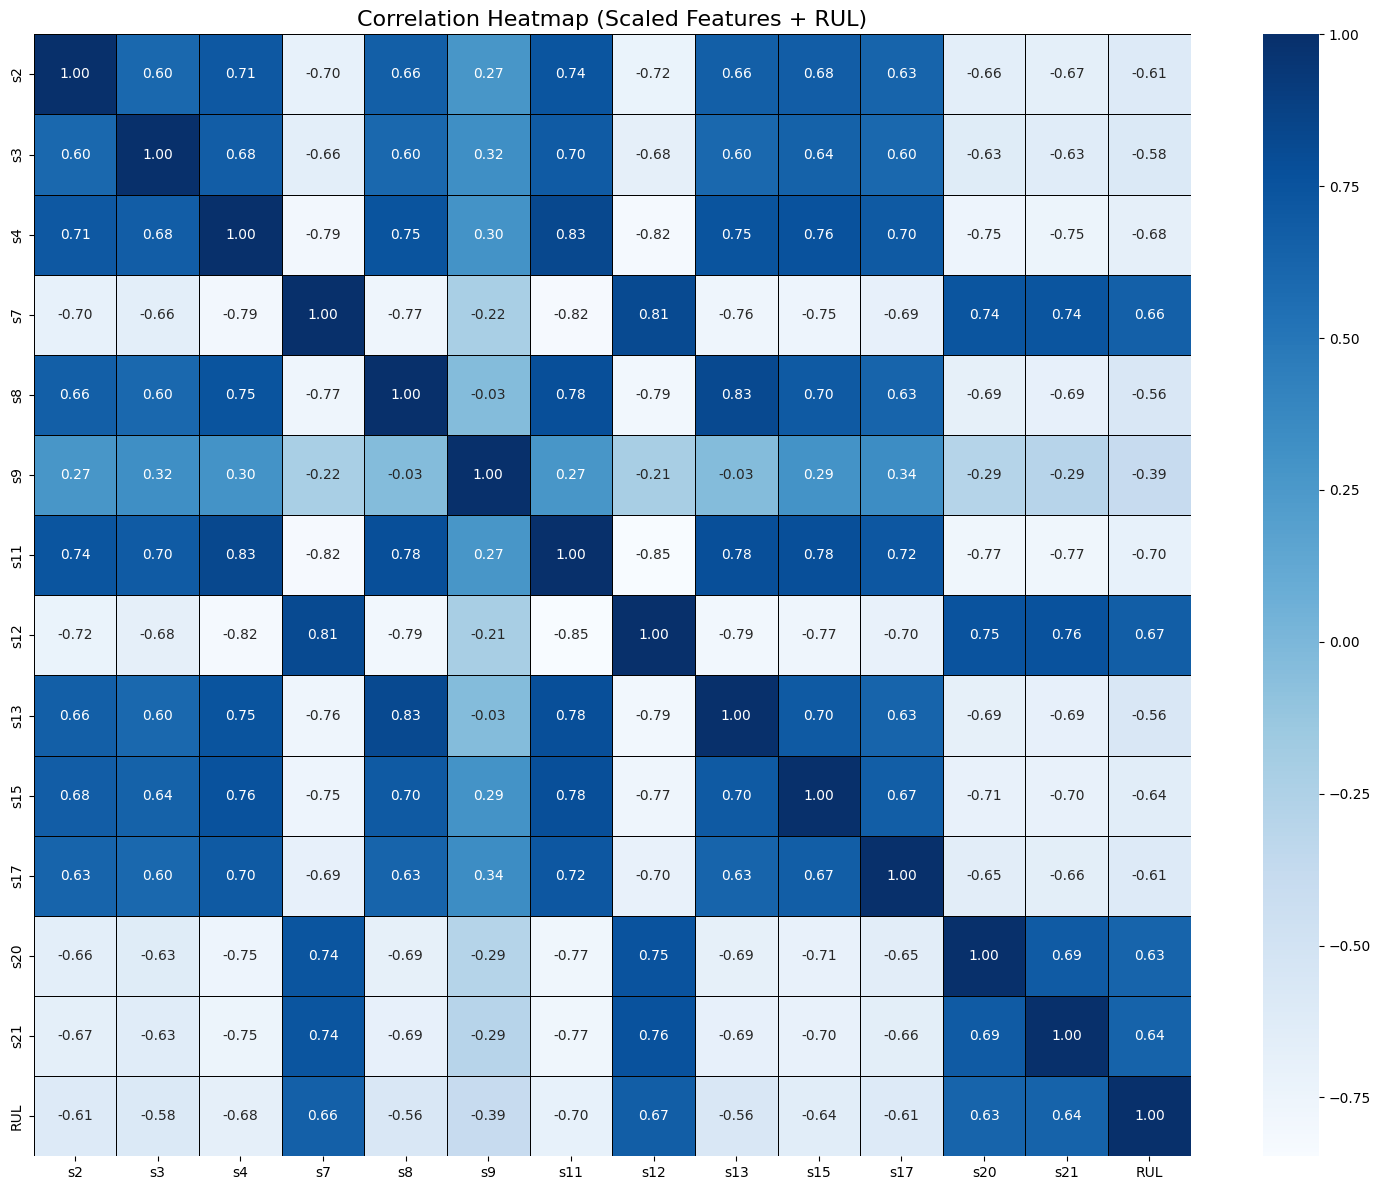

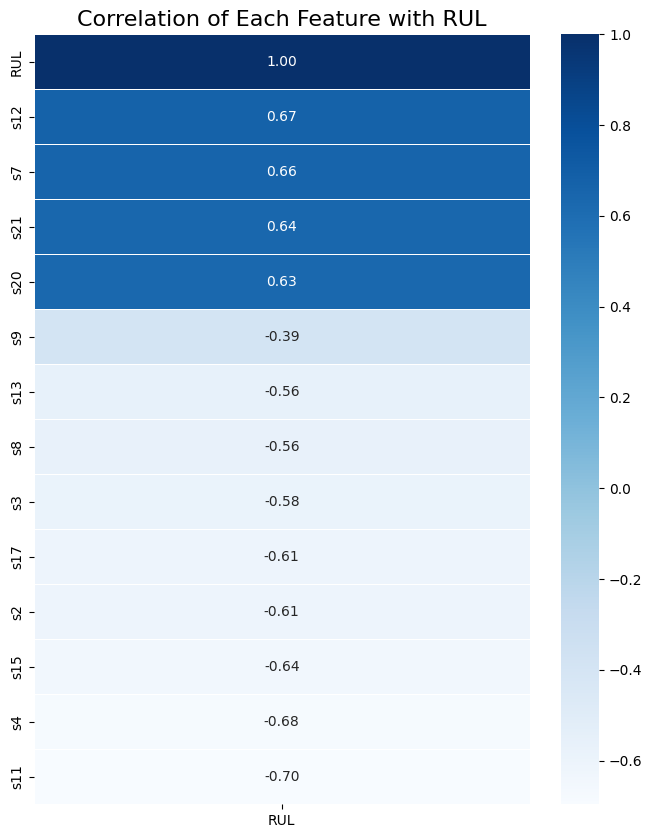

In [6]:
# DATA PREPROCESSING
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.max_columns", None)

# 1. BASIC INFO
print("Train shape :", train_df.shape)
print("Test shape  :", test_df.shape)

print("\n=== TRAIN INFO ===")
display(train_df.info())

print("\n=== Missing Values (Train) ===")
print(train_df.isnull().sum())

display(train_df.describe())

# 2. REMOVE FULL-NULL COLUMNS
null_cols = [c for c in train_df.columns if train_df[c].isnull().all()]
print("\nColumns with ALL NULL:", null_cols)

train_df = train_df.drop(columns=null_cols)
test_df  = test_df.drop(columns=null_cols)

# 3. REMOVE NO-VARIANCE COLUMNS
constant_cols = [c for c in train_df.columns if train_df[c].nunique() <= 1]
print("\nColumns with NO VARIANCE:", constant_cols)

train_df = train_df.drop(columns=constant_cols)
test_df  = test_df.drop(columns=constant_cols)

# 4. REMOVE BANNED COLUMNS
#    (low info / redundant / highly correlated)
ban_cols = [
    "setting1", "setting2", "setting3",
    "s1", "s5", "s6", "s10", "s14", "s16", "s18", "s19"
]

ban_cols = [c for c in ban_cols if c in train_df.columns]  # ensure exists

print("\nDropping banned cols:", ban_cols)

train_df = train_df.drop(columns=ban_cols)
test_df  = test_df.drop(columns=ban_cols)

# 5. FINAL FEATURE LIST
feature_cols = [
    c for c in train_df.columns
    if c not in ["id", "cycle", "RUL"]
]

print("\nFinal usable feature columns:", feature_cols)

# 6. SCALING
scaler_X = MinMaxScaler(feature_range=(0, 1))

train_proc = train_df.copy()
test_proc  = test_df.copy()

train_proc[feature_cols] = scaler_X.fit_transform(train_proc[feature_cols])
test_proc[feature_cols]  = scaler_X.transform(test_proc[feature_cols])

# 7. SORT BY id & cycle
train_proc = train_proc.sort_values(["id", "cycle"]).reset_index(drop=True)
test_proc  = test_proc.sort_values(["id", "cycle"]).reset_index(drop=True)

# 8. HEATMAP
plt.figure(figsize=(15, 12))
corr_matrix = train_proc[feature_cols + ["RUL"]].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar=True,
    linewidths=.5,
    linecolor='black'
)
plt.title("Correlation Heatmap (Scaled Features + RUL)", fontsize=16)
plt.tight_layout()
plt.show()

# If too big, show top 10 correlated features with RUL:
plt.figure(figsize=(8, 10))
corr_with_rul = corr_matrix["RUL"].sort_values(ascending=False)
sns.heatmap(
    corr_with_rul.to_frame(),
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar=True,
    linewidths=.5
)
plt.title("Correlation of Each Feature with RUL", fontsize=16)
plt.show()



## EDA

Total number of engines in training set: 100
Example engine IDs: [ 1  2  3  4  5  6  7  8  9 10]


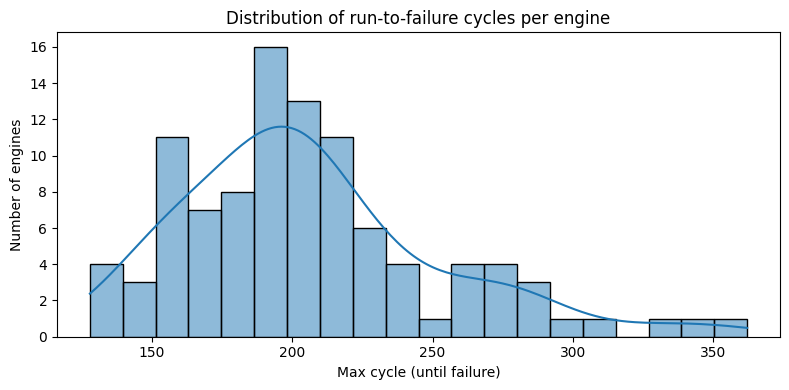

In [7]:
# ==== EDA 1: Engine overview ====
engine_ids = train_df["id"].unique()
print(f"Total number of engines in training set: {len(engine_ids)}")
print("Example engine IDs:", engine_ids[:10])

engine_lengths = train_df.groupby("id")["cycle"].max()

plt.figure(figsize=(8, 4))
sns.histplot(engine_lengths, bins=20, kde=True)
plt.title("Distribution of run-to-failure cycles per engine")
plt.xlabel("Max cycle (until failure)")
plt.ylabel("Number of engines")
plt.tight_layout()
plt.show()


Total sensors: 13
Sensor columns: ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's15', 's17', 's20', 's21']


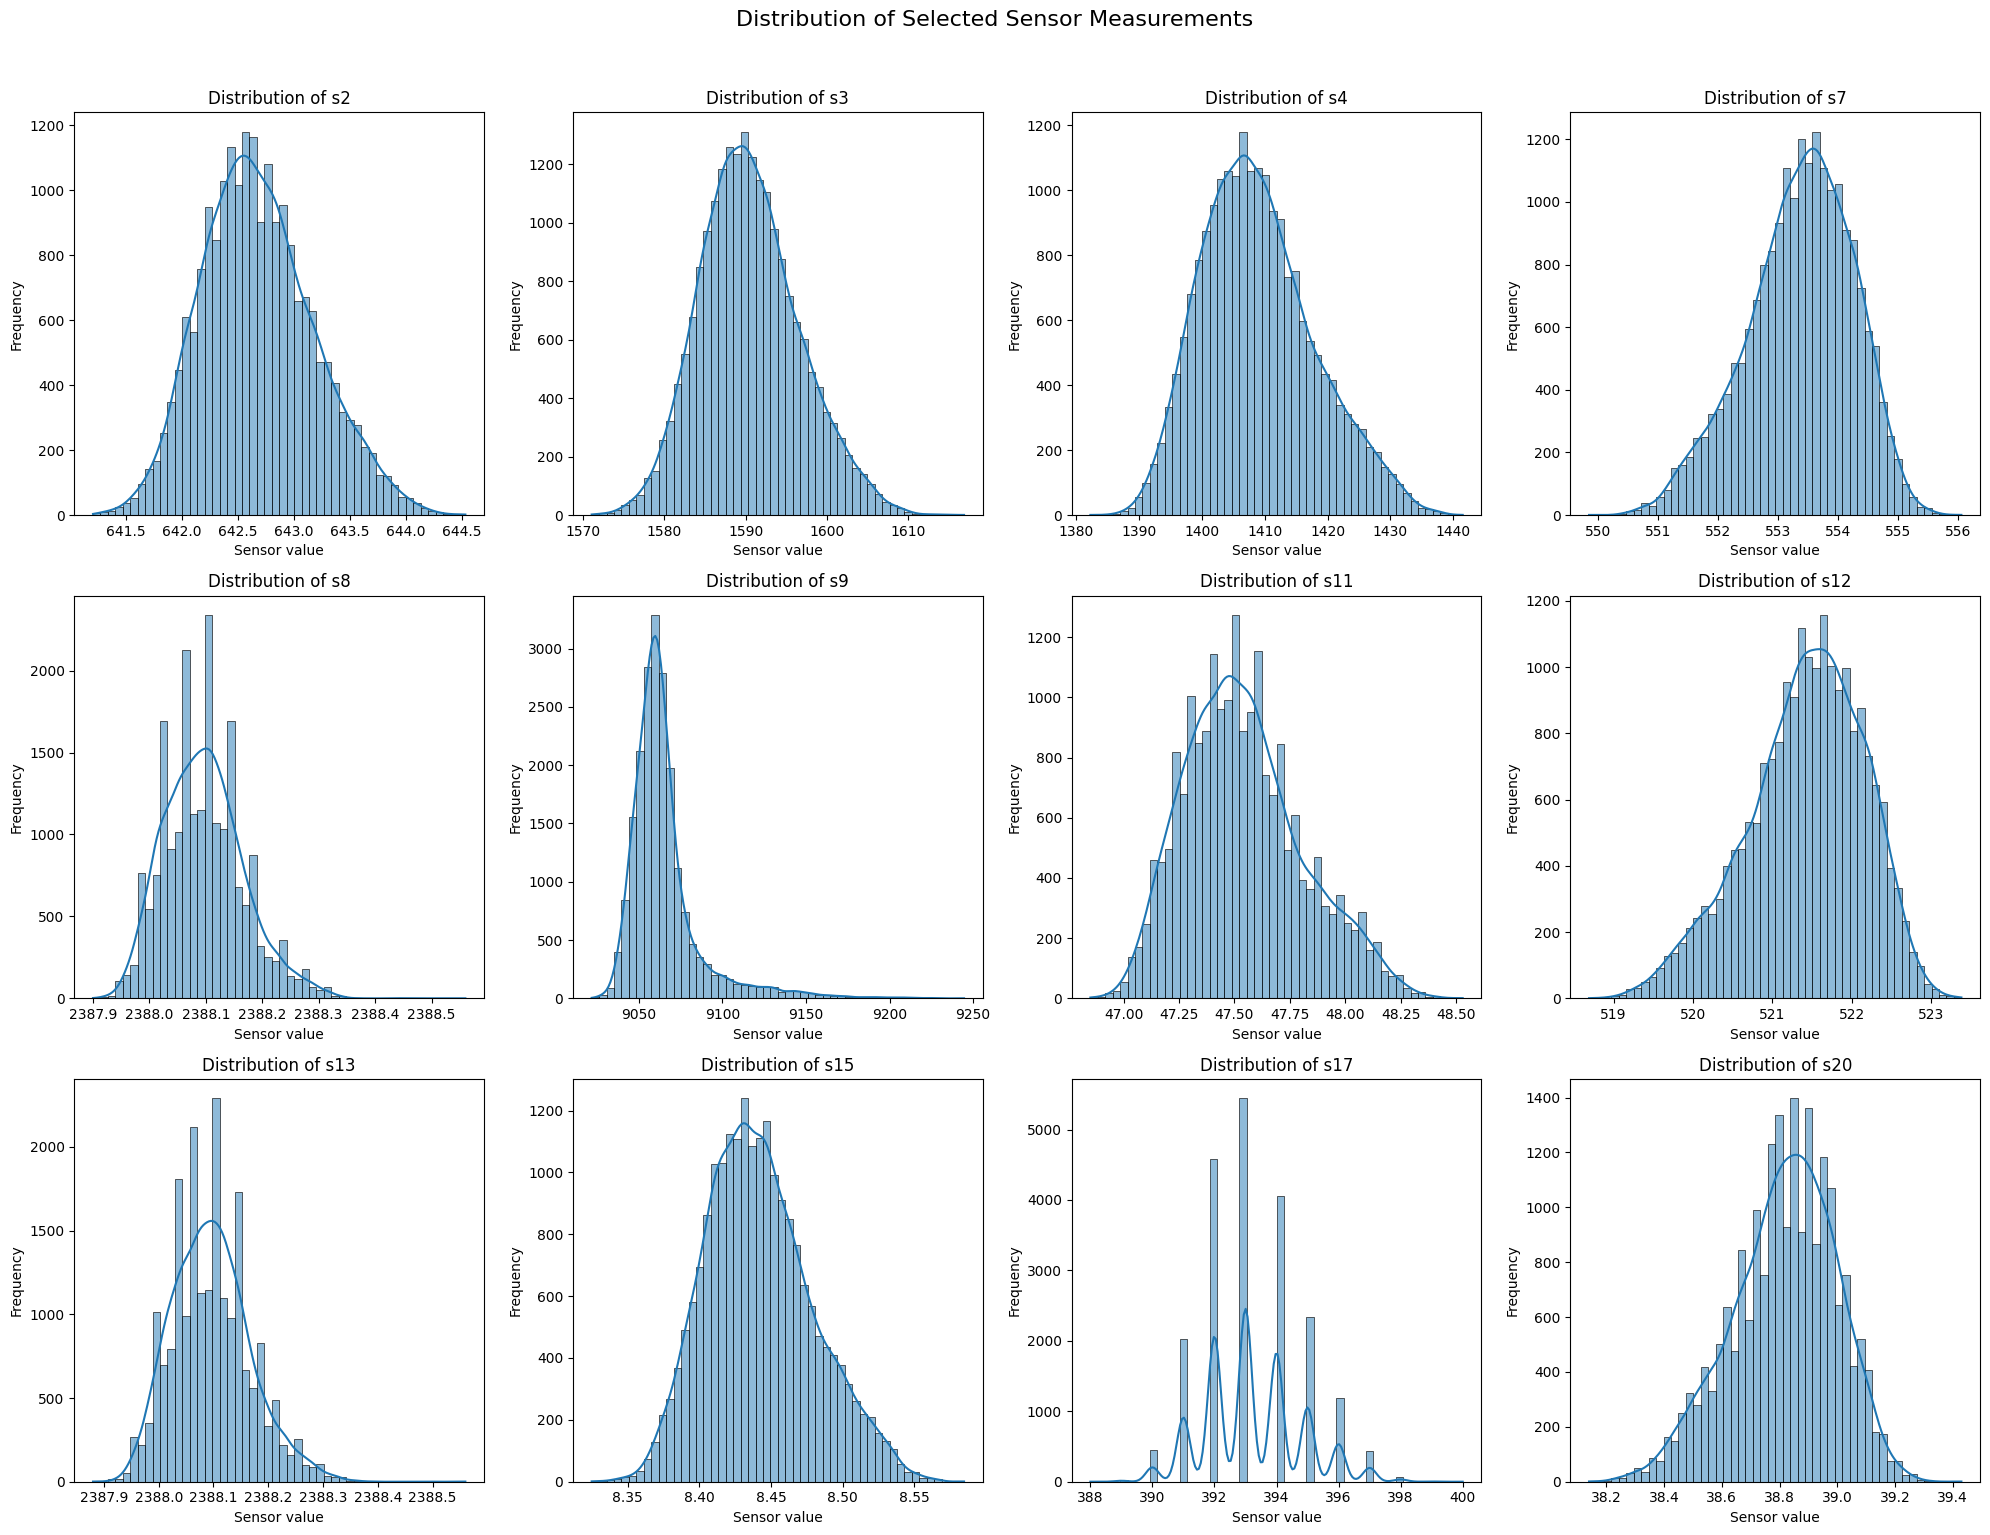

In [8]:
# ==== EDA 2: Distribution of sensor values ====

import matplotlib.pyplot as plt
import seaborn as sns

sensor_cols = [c for c in train_df.columns if c.startswith("s")]
print("Total sensors:", len(sensor_cols))
print("Sensor columns:", sensor_cols)

# Untuk visual awal, pakai 12 sensor pertama
sensors_to_plot = sensor_cols[:12]

# bikin subplots: 3 baris x 4 kolom
n_sensors = len(sensors_to_plot)
n_rows, n_cols = 3, 4   # sesuaikan kalau mau lebih/kurang
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, sensor in enumerate(sensors_to_plot):
    ax = axes[i]
    sns.histplot(train_df[sensor], bins=50, kde=True, ax=ax)
    ax.set_title(f"Distribution of {sensor}", fontsize=12)
    ax.set_xlabel("Sensor value")
    ax.set_ylabel("Frequency")

# hapus subplot kosong kalau sensor < jumlah grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Selected Sensor Measurements", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


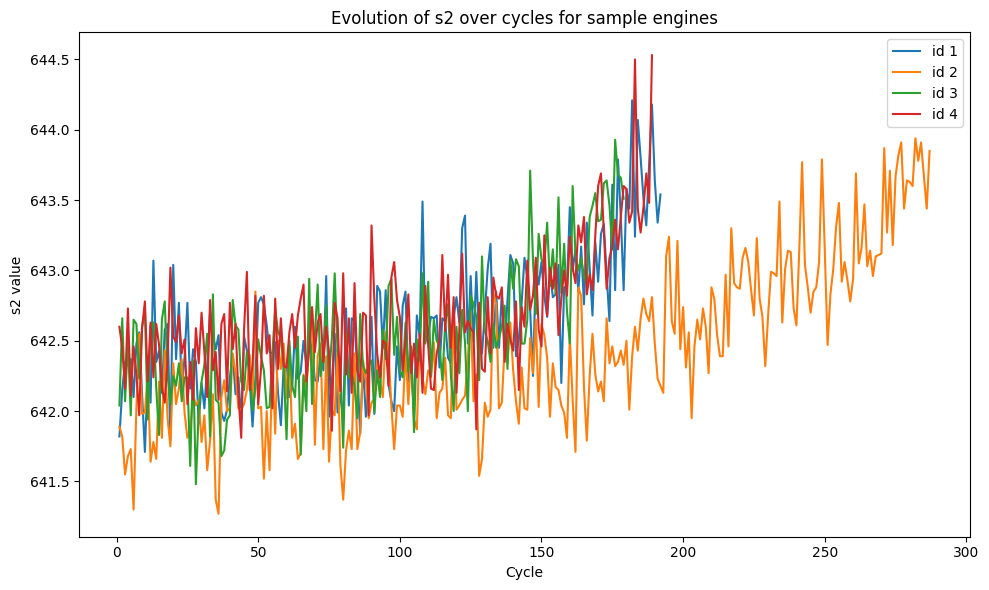

In [9]:
# ==== EDA 3 : Time-series of a sensor across different engines ====

sample_engines = engine_ids[:4]          # ambil 4 engine pertama
sensor_to_show = sensor_cols[0]          # atau ganti misalnya "s2"

plt.figure(figsize=(10, 6))
for eid in sample_engines:
    df_e = train_df[train_df["id"] == eid]
    plt.plot(df_e["cycle"], df_e[sensor_to_show], label=f"id {eid}")

plt.title(f"Evolution of {sensor_to_show} over cycles for sample engines")
plt.xlabel("Cycle")
plt.ylabel(f"{sensor_to_show} value")
plt.legend()
plt.tight_layout()
plt.show()


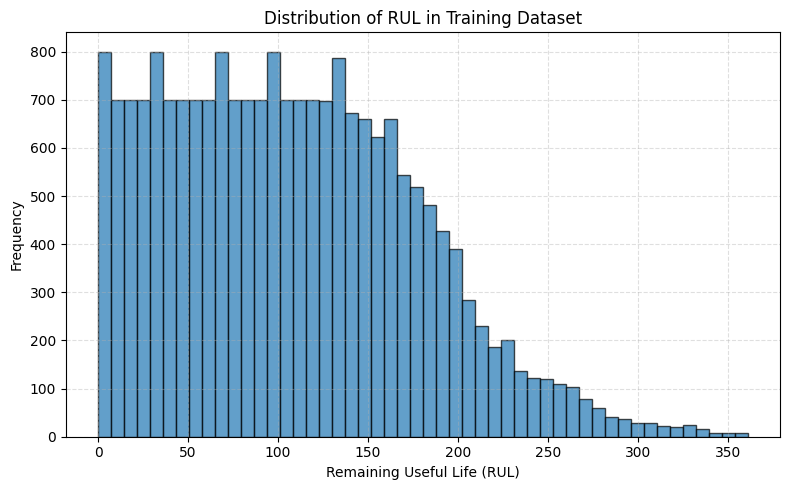

Total sensor columns: 13

Sensor data (mean per engine):


,id,s2,s3,s4,s7,s8,s9,s11,s12,s13,s15,s17,s20,s21
0,1,642.621042,1589.485521,1407.262135,553.439427,2388.110260,9048.265833,47.514063,521.459427,2388.110833,8.436555,392.854167,38.840052,23.306310
1,2,642.435226,1588.181986,1404.265854,553.853484,2388.057213,9062.652439,47.389512,521.811603,2388.053554,8.423983,392.386760,38.901150,23.338997
2,3,642.543743,1588.715084,1405.628994,553.800056,2388.049777,9081.265866,47.427039,521.773966,2388.047430,8.430236,392.754190,38.882793,23.321931
3,4,642.662381,1590.563280,1408.253915,553.443016,2388.079101,9077.366825,47.515132,521.501005,2388.082275,8.439303,393.291005,38.830265,23.294502
4,5,642.451970,1588.153271,1404.878439,553.882342,2388.034201,9083.948253,47.402268,521.866431,2388.029071,8.425968,392.646840,38.891078,23.336284


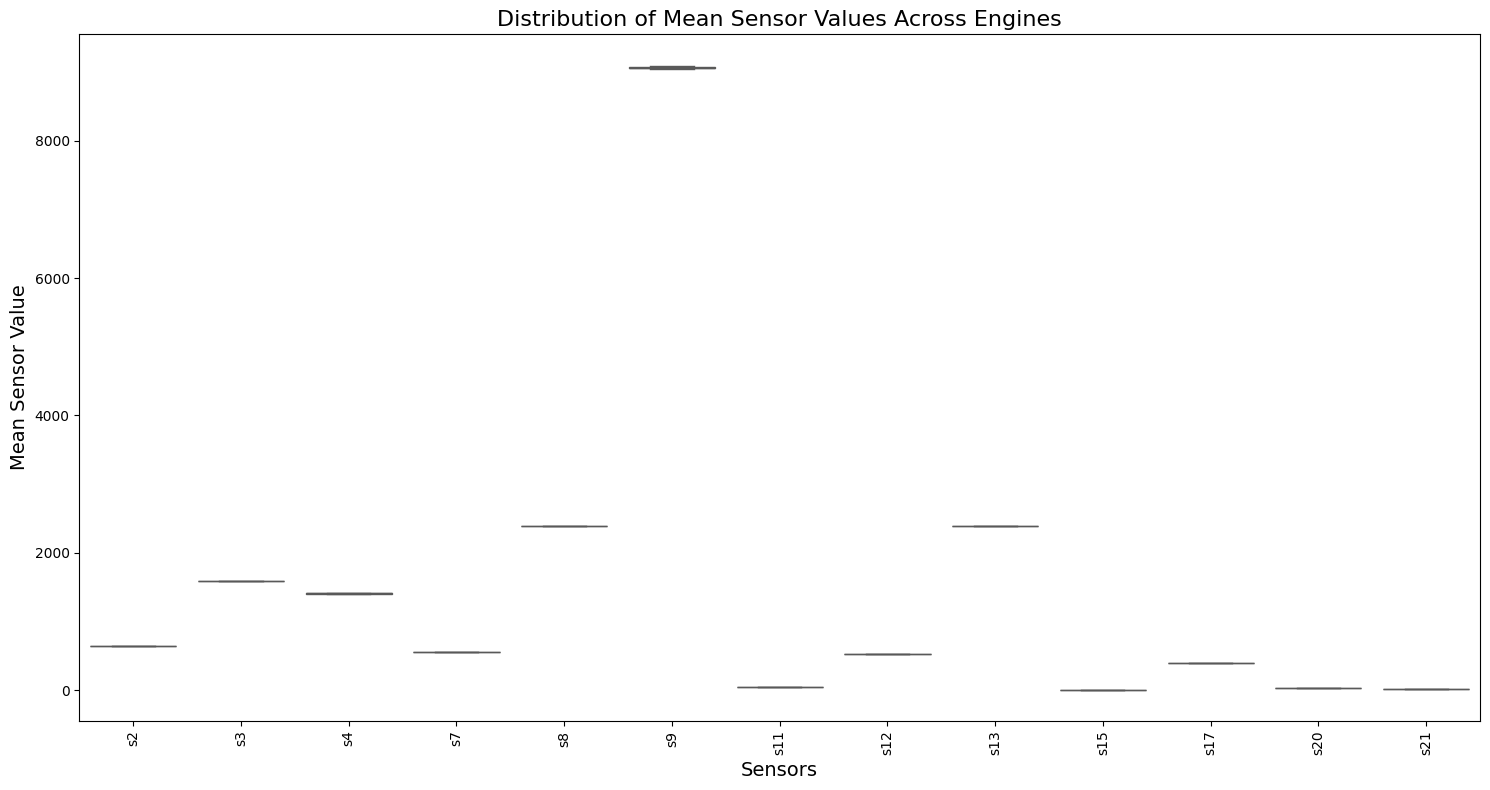

In [10]:
#   EDA: RUL + Sensors Across Engines
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Distribution of RUL
plt.figure(figsize=(8, 5))
plt.hist(train_df["RUL"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Remaining Useful Life (RUL)")
plt.ylabel("Frequency")
plt.title("Distribution of RUL in Training Dataset")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 2) Table: mean sensor values per engine
# pilih semua kolom sensor (nama mulai dengan 's')
sensor_cols = [c for c in train_df.columns if c.startswith("s")]
print("Total sensor columns:", len(sensor_cols))

sensor_data_across_engines = (
    train_df
    .groupby("id")[sensor_cols]
    .mean()
    .reset_index()
)

print("\nSensor data (mean per engine):")
display(sensor_data_across_engines.head())

# 3) Boxplot: distribution of sensor values across engines
plt.figure(figsize=(15, 8))
sns.boxplot(data=sensor_data_across_engines[sensor_cols], palette="Set2")
plt.title("Distribution of Mean Sensor Values Across Engines", fontsize=16)
plt.xlabel("Sensors", fontsize=14)
plt.ylabel("Mean Sensor Value", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


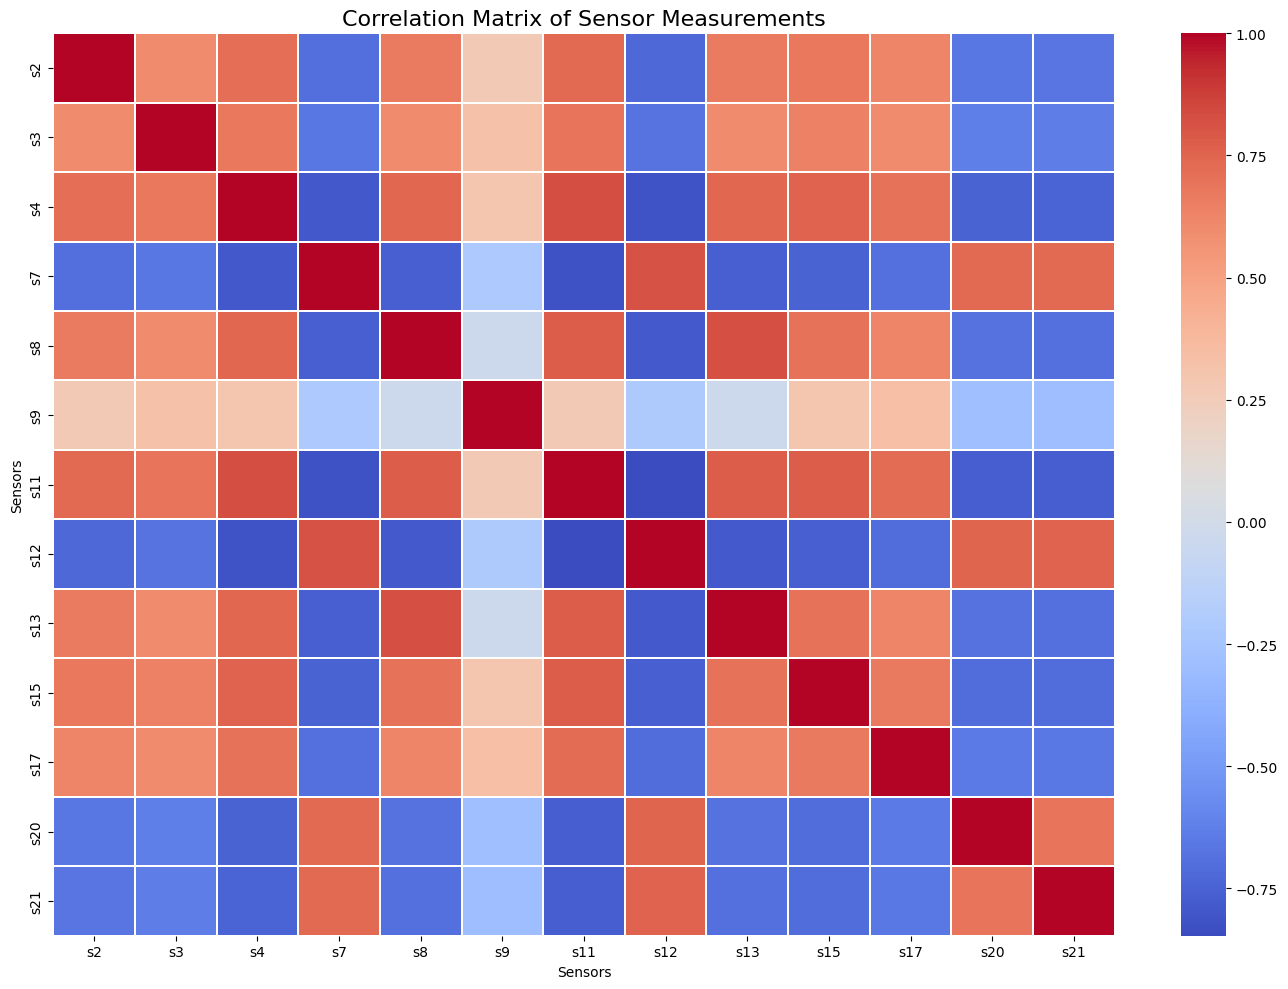

In [11]:
#   EDA: SENSOR CORRELATION MATRIX
sensor_cols = [c for c in train_df.columns if c.startswith("s")]

plt.figure(figsize=(14, 10))
corr_matrix = train_df[sensor_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    linewidths=0.2,
    cbar=True
)
plt.title('Correlation Matrix of Sensor Measurements', fontsize=16)
plt.xlabel('Sensors')
plt.ylabel('Sensors')
plt.tight_layout()
plt.show()


Start RUL threshold: 198.0
End   RUL threshold: 20.0


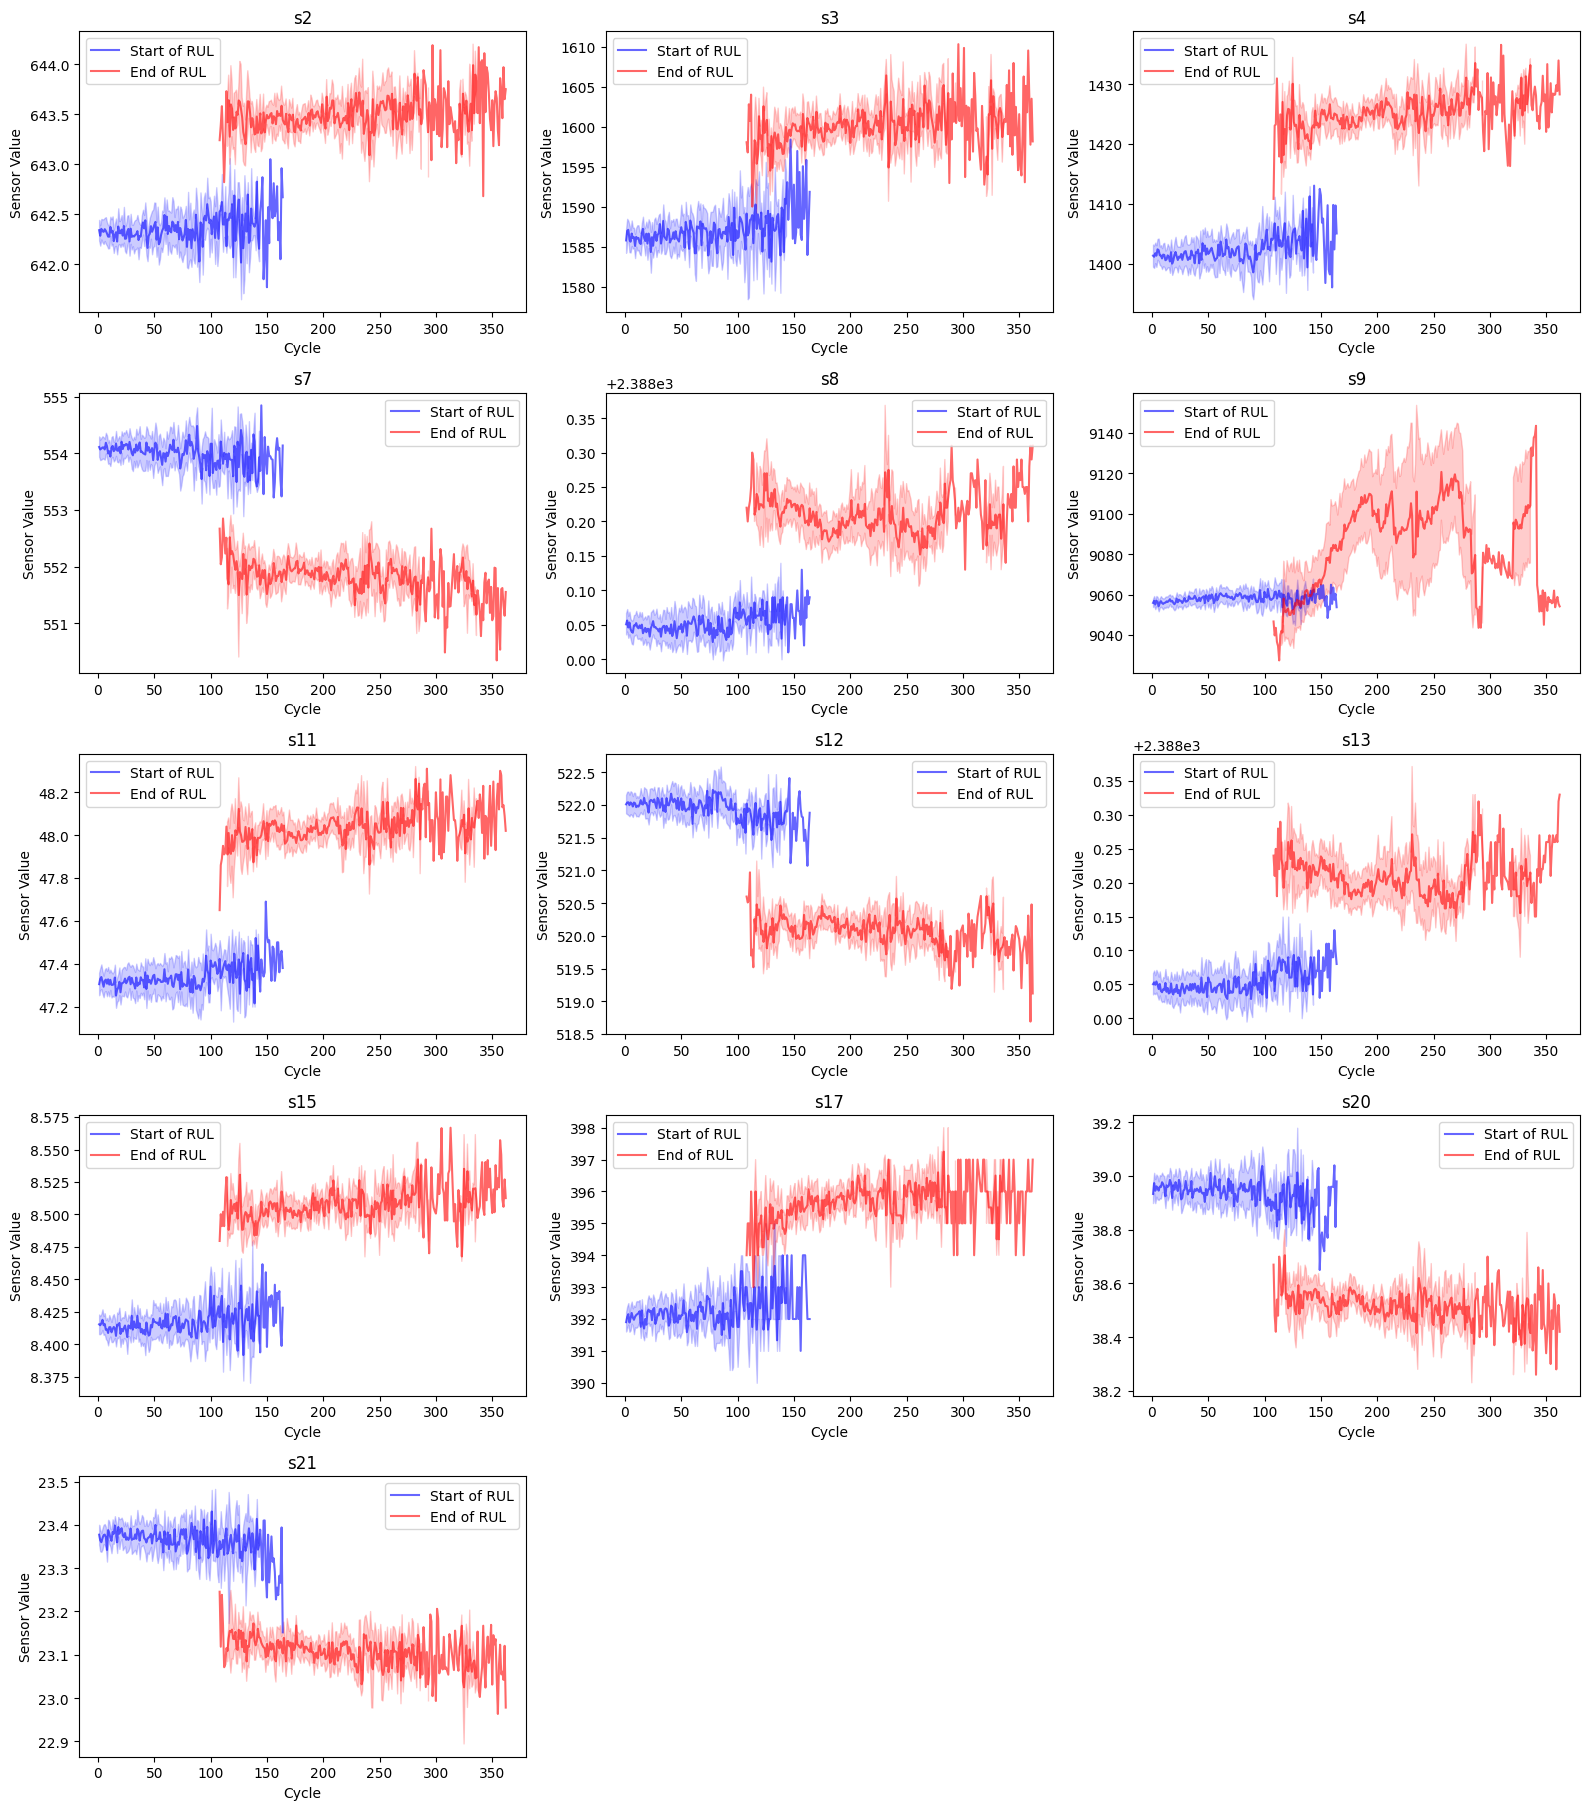

In [12]:
#   EDA: SENSOR TREND (START vs END RUL)

sensor_cols = [c for c in train_df.columns if c.startswith("s")]

# thresholds
start_threshold = train_df["RUL"].quantile(0.9)    # top 10% = RUL tinggi = engine sehat
end_threshold   = train_df["RUL"].quantile(0.1)    # bottom 10% = RUL rendah = engine hampir rusak

start_rul_df = train_df[train_df["RUL"] >= start_threshold]
end_rul_df   = train_df[train_df["RUL"] <= end_threshold]

print("Start RUL threshold:", start_threshold)
print("End   RUL threshold:", end_threshold)

# Plot
plt.figure(figsize=(16, 25))   # tinggi besar karena sensor banyak

for i, sensor in enumerate(sensor_cols, 1):
    plt.subplot(7, 3, i)  # 7x3 grid untuk 21 sensor

    # Plot start-of-life
    sns.lineplot(
        data=start_rul_df, x='cycle', y=sensor,
        label='Start of RUL', color='blue', alpha=0.6
    )

    # Plot end-of-life
    sns.lineplot(
        data=end_rul_df, x='cycle', y=sensor,
        label='End of RUL', color='red', alpha=0.6
    )

    plt.title(sensor)
    plt.xlabel("Cycle")
    plt.ylabel("Sensor Value")

plt.tight_layout()
plt.show()


## Sequence Preparation

In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# 1. Settings
SEQ_LEN =  30       # panjang window (boleh kamu ubah nanti: 20 / 50, dll)
BATCH_SIZE = 64

feature_cols = [
    c for c in train_proc.columns
    if c not in ["id", "cycle", "RUL"]
]

# 2. Helper: build sequences untuk train/val
def build_sequences(df, feature_cols, seq_len=30, target_col="RUL"):
    """
    df: dataframe yang minimal punya kolom ['id', 'cycle', target_col] + feature_cols
    return:
        X: (num_samples, seq_len, num_features)
        y: (num_samples,)
    """
    X_list, y_list = [], []

    for eid, group in df.groupby("id"):
        # pastikan urut
        group = group.sort_values("cycle")
        feat_vals = group[feature_cols].values
        target_vals = group[target_col].values

        # sliding window
        if len(group) < seq_len:
            # terlalu pendek, skip engine ini
            continue

        for i in range(len(group) - seq_len + 1):
            X_list.append(feat_vals[i:i+seq_len])
            y_list.append(target_vals[i+seq_len-1])  # target = RUL di akhir window

    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list).astype(np.float32)

    print(f"Built sequences: X shape = {X.shape}, y shape = {y.shape}")
    return X, y


# 3. Helper: build sequences untuk TEST
#    (hanya 1 window terakhir per engine)
def build_test_sequences(df, feature_cols, seq_len=30):
    X_list, id_list = [], []

    for eid, group in df.groupby("id"):
        group = group.sort_values("cycle")
        feat_vals = group[feature_cols].values

        if len(group) >= seq_len:
            seq = feat_vals[-seq_len:]              # last seq_len cycles
        else:
            # kalau cycle < seq_len → pad di depan dengan nilai pertama
            pad_len = seq_len - len(group)
            pad = np.repeat(feat_vals[0:1], pad_len, axis=0)
            seq = np.concatenate([pad, feat_vals], axis=0)

        X_list.append(seq)
        id_list.append(eid)

    X = np.stack(X_list).astype(np.float32)
    ids = np.array(id_list)
    print(f"Test sequences: X shape = {X.shape}, num ids = {len(ids)}")
    return X, ids

# 4. Train/Val split by engine id
engine_ids = train_proc["id"].unique()
train_ids, val_ids = train_test_split(
    engine_ids, test_size=0.2, random_state=SEED
)

train_seq_df = train_proc[train_proc["id"].isin(train_ids)].copy()
val_seq_df   = train_proc[train_proc["id"].isin(val_ids)].copy()

X_train, y_train = build_sequences(train_seq_df, feature_cols, SEQ_LEN, target_col="RUL")
X_val,   y_val   = build_sequences(val_seq_df,   feature_cols, SEQ_LEN, target_col="RUL")

# test sequences (untuk inference nanti)
X_test, test_ids = build_test_sequences(test_proc, feature_cols, SEQ_LEN)


# 5. PyTorch Dataset & DataLoader
class RULDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.from_numpy(X)
        self.y = None if y is None else torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]


train_dataset = RULDataset(X_train, y_train)
val_dataset   = RULDataset(X_val, y_val)
test_dataset  = RULDataset(X_test, None)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Built sequences: X shape = (14256, 30, 13), y shape = (14256,)
Built sequences: X shape = (3475, 30, 13), y shape = (3475,)
Test sequences: X shape = (97, 30, 13), num ids = 97
Train batches: 223, Val batches: 55


## LSTM Model (PyTorch)

In [14]:
import torch
import torch.nn as nn
from torch.optim import Adam

# 1. LSTM Regressor Model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2,
                 dropout=0.2, bidirectional=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,   # input shape: (batch, seq_len, input_dim)
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        # fully connected layer dari last hidden state → 1 output (RUL)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * self.num_directions, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        lstm_out, (hn, cn) = self.lstm(x)
        # ambil last time step output
        # lstm_out: (batch, seq_len, hidden_dim * num_directions)
        last_out = lstm_out[:, -1, :]          # (batch, hidden_dim * num_directions)
        out = self.fc(last_out)                # (batch, 1)
        return out.squeeze(-1)                 # (batch,)

# 2. Init model, loss, optimizer
input_dim = len(feature_cols)
print("Input feature dim:", input_dim)

model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=64,
    num_layers=2,
    dropout=0.3,
    bidirectional=False   # bisa kamu ubah ke True nanti
).to(DEVICE)

# Loss: MAE (sesuai evaluation di tugas)
criterion = nn.L1Loss()

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-3)

# (Optional) Scheduler – bisa dipakai nanti kalau mau
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Helper: cek jumlah parameter
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print("Trainable parameters:", count_parameters(model))


Input feature dim: 13
LSTMRegressor(
  (lstm): LSTM(13, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Trainable parameters: 57729


## Training + Validation Loop

In [15]:
import time
import copy
from sklearn.metrics import mean_absolute_error

NUM_EPOCHS = 30   # bisa kamu ubah nanti (10–50)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        running_loss += loss.item() * X_batch.size(0)

        all_preds.append(outputs.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)

    # hitung MAE pakai sklearn (harusnya sama dengan L1Loss, tapi buat cross-check)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    mae = mean_absolute_error(all_targets, all_preds)

    return epoch_loss, mae


# ============================
#  MAIN TRAINING LOOP
# ============================
best_val_mae = float("inf")
best_model_wts = copy.deepcopy(model.state_dict())

train_history = []
val_history = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_mae = evaluate(model, val_loader, criterion, DEVICE)

    # scheduler (opsional)
    scheduler.step()

    elapsed = time.time() - start_time

    train_history.append(train_loss)
    val_history.append(val_mae)

    print(
        f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
        f"Train Loss (MAE): {train_loss:.4f} | "
        f"Val Loss (MAE): {val_loss:.4f} | "
        f"Val MAE: {val_mae:.4f} | "
        f"Time: {elapsed:.1f}s"
    )

    # simpan model terbaik
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"New best model saved (Val MAE = {best_val_mae:.4f})")

# load best weights
model.load_state_dict(best_model_wts)
print(f"\nTraining complete. Best Val MAE = {best_val_mae:.4f}")


Epoch 01/30 | Train Loss (MAE): 70.8701 | Val Loss (MAE): 49.1805 | Val MAE: 49.1805 | Time: 1.0s
New best model saved (Val MAE = 49.1805)
Epoch 02/30 | Train Loss (MAE): 51.4534 | Val Loss (MAE): 48.9775 | Val MAE: 48.9775 | Time: 0.8s
New best model saved (Val MAE = 48.9775)
Epoch 03/30 | Train Loss (MAE): 51.4998 | Val Loss (MAE): 48.9784 | Val MAE: 48.9784 | Time: 0.8s
Epoch 04/30 | Train Loss (MAE): 51.4073 | Val Loss (MAE): 48.9965 | Val MAE: 48.9965 | Time: 0.8s
Epoch 05/30 | Train Loss (MAE): 51.3329 | Val Loss (MAE): 48.9756 | Val MAE: 48.9756 | Time: 0.8s
New best model saved (Val MAE = 48.9756)
Epoch 06/30 | Train Loss (MAE): 51.3874 | Val Loss (MAE): 48.9849 | Val MAE: 48.9849 | Time: 0.8s
Epoch 07/30 | Train Loss (MAE): 51.1838 | Val Loss (MAE): 48.9796 | Val MAE: 48.9796 | Time: 0.8s
Epoch 08/30 | Train Loss (MAE): 51.4893 | Val Loss (MAE): 48.9750 | Val MAE: 48.9750 | Time: 0.8s
New best model saved (Val MAE = 48.9750)
Epoch 09/30 | Train Loss (MAE): 51.4082 | Val Loss (

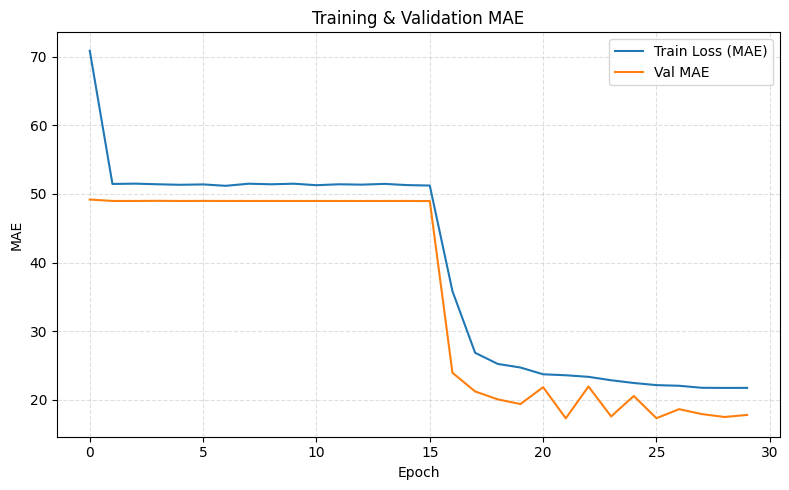

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(train_history, label="Train Loss (MAE)")
plt.plot(val_history, label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training & Validation MAE")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [17]:
@torch.no_grad()
def predict(model, loader, device):
    model.eval()
    all_preds = []

    for X_batch in loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)           # (batch,)
        all_preds.append(outputs.cpu().numpy())

    preds = np.concatenate(all_preds)
    return preds
# 1. Generate predictions
test_preds = predict(model, test_loader, DEVICE)
print("Raw predictions shape:", test_preds.shape)

# Optional: kalau ada prediksi negatif, kita clip ke 0 (RUL tidak mungkin negatif)
test_preds = np.clip(test_preds, 0, None)

# 2. Build submission DataFrame
submission = pd.DataFrame({
    "id": test_ids,         # dari build_test_sequences()
    "RUL": test_preds       # nama kolom harus sama seperti sample_submission
})

# Sort by id biar rapi
submission = submission.sort_values("id").reset_index(drop=True)

display(submission.head())
print("Submission shape:", submission.shape)

# 3. Save to CSV
submission_file = "submission_lstm.csv"
submission.to_csv(submission_file, index=False)
print(f"Saved submission file: {submission_file}")


Raw predictions shape: (97,)


,id,RUL
0,1,117.583183
1,2,135.924179
2,3,50.696266
3,4,72.097687
4,5,92.123550


Submission shape: (97, 2)
Saved submission file: submission_lstm.csv


In [18]:
from google.colab import files
files.download("submission_lstm.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## LSTM + Attention

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam

class LSTMAttentionRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2,
                 attn_dim=64, dropout=0.2, bidirectional=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # ----- LSTM -----
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,   # (batch, seq_len, input_dim)
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        # ----- Attention -----
        # additive attention: score_t = v^T tanh(W h_t)
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim * self.num_directions, attn_dim),
            nn.Tanh(),
            nn.Linear(attn_dim, 1)
        )

        # ----- Fully connected head -----
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * self.num_directions, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)              # (batch, seq_len, H*D)

        # compute attention scores per time step
        attn_scores = self.attn(lstm_out)       # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # softmax over time

        # context vector = weighted sum of all time steps
        context = (lstm_out * attn_weights).sum(dim=1)    # (batch, H*D)

        # regression head
        out = self.fc(context)                  # (batch, 1)
        return out.squeeze(-1)                  # (batch,)

In [ ]:
input_dim = len(feature_cols)
print("Input feature dim:", input_dim)

model = LSTMAttentionRegressor(
    input_dim=input_dim,
    hidden_dim=64,      # boleh kamu tune
    num_layers=2,
    attn_dim=64,
    dropout=0.3,
    bidirectional=False  # bisa dicoba True nanti kalau mau
).to(DEVICE)

criterion = nn.L1Loss()            # MAE
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print("Trainable parameters:", count_parameters(model))

Input feature dim: 13
LSTMAttentionRegressor(
  (lstm): LSTM(13, 64, num_layers=2, batch_first=True, dropout=0.3)
  (attn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Trainable parameters: 61954


In [ ]:
submission_file = "submission_lstm_attn.csv"
submission.to_csv(submission_file, index=False)
print(f"Saved submission file: {submission_file}")

Saved submission file: submission_lstm_attn.csv


In [ ]:
from google.colab import files
files.download("submission_lstm_attn.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## CNN-LSTM + BiLSTM + Attention + Multi-Config Ensemble

In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [43]:
from google.colab import files
uploaded = files.upload()

Saving 114-artificial-intelligence-hw-3 (1).zip to 114-artificial-intelligence-hw-3 (1).zip


In [46]:
!unzip -o "114-artificial-intelligence-hw-3 (1).zip"

Archive:  114-artificial-intelligence-hw-3 (1).zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [47]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

In [48]:
print(f"Train: {train_df.shape}, Test: {test_df.shape}")
train_df.head()

Train: (20631, 27), Test: (12680, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,189
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,187


In [49]:
# Beberapa konfigurasi untuk di-ensemble
CONFIGS = [
    {'seq_len': 50, 'rul_cap': 125, 'hidden': 64, 'dropout': 0.30},
    {'seq_len': 40, 'rul_cap': 130, 'hidden': 64, 'dropout': 0.25},
    {'seq_len': 50, 'rul_cap': 120, 'hidden': 80, 'dropout': 0.30},
    {'seq_len': 30, 'rul_cap': 125, 'hidden': 64, 'dropout': 0.35},
]

# Kolom sensor yang dihapus (near-constant di dataset NASA)
REMOVE_COLS = ['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19']

all_cols = train_df.columns.tolist()
feature_cols = [c for c in all_cols if c not in ['id', 'cycle', 'RUL'] + REMOVE_COLS]
print(f"Num features kept: {len(feature_cols)}")
print(feature_cols)

Num features kept: 16
['setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


In [50]:
scaler = StandardScaler()

train_scaled = train_df.copy()
test_scaled  = test_df.copy()

train_scaled[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_scaled[feature_cols]  = scaler.transform(test_df[feature_cols])

In [51]:
def create_sequences(df, seq_length, feature_cols, rul_cap, is_train=True):
    """
    df         : train_scaled / test_scaled
    seq_length : panjang window
    rul_cap    : nilai maksimum RUL untuk training (clip)
    is_train   : True => return (X,y), False => hanya X
    """
    sequences = []
    labels = []

    for eid in df['id'].unique():
        engine = df[df['id'] == eid].sort_values('cycle')
        data = engine[feature_cols].values  # (T, F)

        if is_train:
            rul = engine['RUL'].values.clip(max=rul_cap)

            # sliding window
            for i in range(len(data) - seq_length + 1):
                seq = data[i:i+seq_length]
                target = rul[i + seq_length - 1]
                sequences.append(seq)
                labels.append(target)
        else:
            # untuk test: ambil window terakhir; kalau < seq_len → pad di depan
            if len(data) >= seq_length:
                seq = data[-seq_length:]
            else:
                pad_len = seq_length - len(data)
                pad = np.tile(data[0], (pad_len, 1))
                seq = np.vstack([pad, data])
            sequences.append(seq)

    X = np.array(sequences, dtype=np.float32)
    if is_train:
        y = np.array(labels, dtype=np.float32)
        return X, y
    else:
        return X

In [52]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.att = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_out):
        # lstm_out: (B, T, H)
        weights = torch.softmax(self.att(lstm_out), dim=1)  # (B, T, 1)
        context = torch.sum(weights * lstm_out, dim=1)      # (B, H)
        return context, weights


class CNNLSTMAttention(nn.Module):
    def __init__(self, n_features, hidden_size=64, dropout=0.3):
        super().__init__()
        # CNN over time
        self.conv1 = nn.Conv1d(n_features, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)

        # LSTM
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        self.attention = Attention(hidden_size * 2)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # x: (B, T, F)
        x = x.permute(0, 2, 1)                     # (B, F, T)
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # (B, 32, T/2)
        x = torch.relu(self.bn2(self.conv2(x)))             # (B, 64, T/2)
        x = x.permute(0, 2, 1)                     # (B, T/2, 64)
        lstm_out, _ = self.lstm(x)                # (B, T/2, 2H)
        context, _ = self.attention(lstm_out)     # (B, 2H)
        out = self.fc(context)                    # (B, 1)
        return out.squeeze(-1)                    # (B,)


class BiLSTMAttention(nn.Module):
    def __init__(self, n_features, hidden_size=64, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.attention = Attention(hidden_size * 2)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_size * 2),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)               # (B, T, 2H)
        context, _ = self.attention(lstm_out)    # (B, 2H)
        out = self.fc(context)                   # (B, 1)
        return out.squeeze(-1)

In [55]:
def train_model(model, train_loader, val_loader, epochs=200, patience=25, lr=1e-3):
    criterion = nn.L1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # HAPUS verbose=...
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    best_val = float('inf')
    best_state = None
    wait = 0

    for epoch in range(1, epochs+1):
        # ---- train ----
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * len(X)

        train_loss /= len(train_loader.dataset)

        # ---- val ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)
                preds = model(X)
                loss = criterion(preds, y)
                val_loss += loss.item() * len(X)

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1

        if epoch % 25 == 0 or epoch == 1:
            print(f"  Epoch {epoch:03d} | Train={train_loss:.4f} | Val={val_loss:.4f} | Best={best_val:.4f}")

        if wait >= patience:
            print(f"  Early stopping at epoch {epoch}")
            break

    model.load_state_dict(best_state)
    return model, best_val

In [56]:
all_predictions = []  # list of arrays (n_test,)
all_weights = []      # list of scalars

for i, cfg in enumerate(CONFIGS):
    print("\n" + "="*70)
    print(f"Config {i+1}/{len(CONFIGS)} | seq_len={cfg['seq_len']} | rul_cap={cfg['rul_cap']} "
          f"| hidden={cfg['hidden']} | dropout={cfg['dropout']}")
    print("="*70)

    # 1. buat sequence train & test untuk config ini
    X_train, y_train = create_sequences(
        train_scaled, cfg['seq_len'], feature_cols, cfg['rul_cap'], is_train=True
    )
    X_test = create_sequences(
        test_scaled, cfg['seq_len'], feature_cols, cfg['rul_cap'], is_train=False
    )

    # 2. train/val split (random shuffle)
    idx = np.random.permutation(len(X_train))
    split = int(0.85 * len(idx))
    train_idx, val_idx = idx[:split], idx[split:]

    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                      torch.tensor(y_tr, dtype=torch.float32)),
        batch_size=256,
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                      torch.tensor(y_val, dtype=torch.float32)),
        batch_size=256,
        shuffle=False
    )

    n_features = X_train.shape[2]

    # -------- CNN-LSTM-Attention --------
    print("\n  Training CNN-LSTM-Attention ...")
    torch.manual_seed(SEED + i)
    model1 = CNNLSTMAttention(n_features, hidden_size=cfg['hidden'], dropout=cfg['dropout']).to(device)
    model1, val1 = train_model(model1, train_loader, val_loader)

    # -------- BiLSTM-Attention --------
    print("\n  Training BiLSTM-Attention ...")
    torch.manual_seed(SEED + i + 100)
    model2 = BiLSTMAttention(n_features, hidden_size=cfg['hidden'], dropout=cfg['dropout']).to(device)
    model2, val2 = train_model(model2, train_loader, val_loader)

    # -------- Predict test untuk config ini --------
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    model1.eval()
    model2.eval()
    with torch.no_grad():
        pred1 = model1(X_test_t).cpu().numpy()
        pred2 = model2(X_test_t).cpu().numpy()

    pred_cfg = (pred1 + pred2) / 2.0   # ensemble 2 model untuk config ini
    pred_cfg = pred_cfg.reshape(-1)    # (n_test,)

    # weight config ini = 1 / avg(val_loss)  (semakin kecil val → bobot besar)
    weight_cfg = 1.0 / ( (val1 + val2)/2.0 + 1e-8 )

    all_predictions.append(pred_cfg)
    all_weights.append(weight_cfg)

    print(f"  Config {i+1} done. val1={val1:.4f}, val2={val2:.4f}, weight={weight_cfg:.4f}")


Config 1/4 | seq_len=50 | rul_cap=125 | hidden=64 | dropout=0.3

  Training CNN-LSTM-Attention ...
  Epoch 001 | Train=70.2517 | Val=59.9084 | Best=59.9084
  Epoch 025 | Train=11.3206 | Val=4.8868 | Best=4.8868
  Epoch 050 | Train=10.2559 | Val=5.2528 | Best=3.7568
  Epoch 075 | Train=9.9704 | Val=4.0884 | Best=3.0256
  Epoch 100 | Train=9.3474 | Val=3.1901 | Best=2.5929
  Epoch 125 | Train=9.2576 | Val=3.0610 | Best=2.1840
  Epoch 150 | Train=9.1392 | Val=2.2767 | Best=2.0687
  Early stopping at epoch 157

  Training BiLSTM-Attention ...
  Epoch 001 | Train=69.6484 | Val=62.9688 | Best=62.9688
  Epoch 025 | Train=12.5734 | Val=7.5107 | Best=6.6506
  Epoch 050 | Train=8.0361 | Val=5.1445 | Best=4.2779
  Epoch 075 | Train=7.1932 | Val=4.0168 | Best=2.9632
  Epoch 100 | Train=6.8337 | Val=2.5977 | Best=2.3005
  Epoch 125 | Train=6.5295 | Val=2.1456 | Best=1.7422
  Epoch 150 | Train=6.3844 | Val=1.5524 | Best=1.4668
  Epoch 175 | Train=6.3608 | Val=1.3868 | Best=1.3868
  Epoch 200 | Trai

In [57]:
# Convert lists to arrays
all_predictions = np.stack(all_predictions, axis=0)  # (n_cfg, n_test)
all_weights = np.array(all_weights)
all_weights = all_weights / all_weights.sum()        # normalisasi

print("Ensemble weights per config:", all_weights)

# Weighted average across configs
final_pred = np.average(all_predictions, axis=0, weights=all_weights)
final_pred = np.clip(final_pred, 0, None)   # RUL tidak boleh negatif

# id untuk submission = satu id per engine di test
test_engine_ids = test_df['id'].unique()
print("Num test engines:", len(test_engine_ids), " | len(final_pred):", len(final_pred))

submission = pd.DataFrame({
    "id": test_engine_ids,
    "RUL": final_pred
}).sort_values("id").reset_index(drop=True)

submission.head()
submission.to_csv("submission_cnn_lstm_attn_ensemble_tuned.csv", index=False)
print("Saved submission_cnn_lstm_attn_ensemble_tuned.csv")

Ensemble weights per config: [0.26817184 0.22890084 0.31118613 0.19174119]
Num test engines: 97  | len(final_pred): 97
Saved submission_cnn_lstm_attn_ensemble_tuned.csv


In [58]:
from google.colab import files
files.download("submission_cnn_lstm_attn_ensemble_tuned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
all_predictions = []  # list of arrays (n_cfg, n_test)
cfg_val_scores = []   # simpan avg validation loss per config

for i, cfg in enumerate(CONFIGS):
    print("\n" + "="*70)
    print(f"Config {i+1}/{len(CONFIGS)} | seq_len={cfg['seq_len']} | "
          f"rul_cap={cfg['rul_cap']} | hidden={cfg['hidden']} | dropout={cfg['dropout']}")
    print("="*70)

    # 1. build sequences
    X_train, y_train = create_sequences(
        train_scaled, cfg['seq_len'], feature_cols, cfg['rul_cap'], is_train=True
    )
    X_test = create_sequences(
        test_scaled, cfg['seq_len'], feature_cols, cfg['rul_cap'], is_train=False
    )

    # 2. train/val split
    idx = np.random.permutation(len(X_train))
    split = int(0.85 * len(idx))
    train_idx, val_idx = idx[:split], idx[split:]

    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                      torch.tensor(y_tr, dtype=torch.float32)),
        batch_size=256,
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                      torch.tensor(y_val, dtype=torch.float32)),
        batch_size=256,
        shuffle=False
    )

    n_features = X_train.shape[2]

    # -------- CNN-LSTM-Attention --------
    print("\n  Training CNN-LSTM-Attention ...")
    torch.manual_seed(SEED + i)
    model1 = CNNLSTMAttention(n_features, hidden_size=cfg['hidden'], dropout=cfg['dropout']).to(device)
    model1, val1 = train_model(model1, train_loader, val_loader)

    # -------- BiLSTM-Attention --------
    print("\n  Training BiLSTM-Attention ...")
    torch.manual_seed(SEED + i + 100)
    model2 = BiLSTMAttention(n_features, hidden_size=cfg['hidden'], dropout=cfg['dropout']).to(device)
    model2, val2 = train_model(model2, train_loader, val_loader)

    # rata-rata validation loss untuk config ini
    avg_val = (val1 + val2) / 2.0
    cfg_val_scores.append(avg_val)

    # -------- Predict test untuk config ini --------
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    model1.eval()
    model2.eval()
    with torch.no_grad():
        pred1 = model1(X_test_t).cpu().numpy()
        pred2 = model2(X_test_t).cpu().numpy()

    pred_cfg = (pred1 + pred2) / 2.0          # ensemble 2 model
    pred_cfg = pred_cfg.reshape(-1)           # (n_test,)

    all_predictions.append(pred_cfg)

    print(f"  Config {i+1} done. val1={val1:.4f}, val2={val2:.4f}, avg_val={avg_val:.4f}")

# ----------------- ENSEMBLE TUNING -----------------
all_predictions = np.stack(all_predictions, axis=0)   # (n_cfg, n_test)
cfg_val_scores = np.array(cfg_val_scores)

print("Avg val loss per config:", cfg_val_scores)

# 1) Stronger weighting: 1 / (val^2)
weights = 1.0 / (cfg_val_scores ** 2 + 1e-8)
weights = weights / weights.sum()
print("Ensemble weights (1/val^2):", weights)

final_pred_strong = np.average(all_predictions, axis=0, weights=weights)
final_pred_strong = np.clip(final_pred_strong, 0, None)

# 2) Top-2 configs only (kadang ini lebih bagus)
top2_idx = np.argsort(cfg_val_scores)[:2]
print("Top-2 config indices:", top2_idx, " | scores:", cfg_val_scores[top2_idx])

final_pred_top2 = np.mean(all_predictions[top2_idx, :], axis=0)
final_pred_top2 = np.clip(final_pred_top2, 0, None)


Config 1/4 | seq_len=50 | rul_cap=125 | hidden=64 | dropout=0.3

  Training CNN-LSTM-Attention ...
  Epoch 001 | Train=70.3596 | Val=59.2625 | Best=59.2625
  Epoch 025 | Train=10.8296 | Val=5.3116 | Best=5.3116
  Epoch 050 | Train=10.0514 | Val=3.8064 | Best=3.7579
  Epoch 075 | Train=9.8002 | Val=3.2080 | Best=3.0721
  Epoch 100 | Train=9.5311 | Val=3.3719 | Best=2.8200
  Epoch 125 | Train=9.5981 | Val=3.0043 | Best=2.5395
  Early stopping at epoch 143

  Training BiLSTM-Attention ...
  Epoch 001 | Train=69.7155 | Val=62.2225 | Best=62.2225
  Epoch 025 | Train=11.1519 | Val=6.6638 | Best=6.6638
  Epoch 050 | Train=8.9979 | Val=4.7360 | Best=4.3907
  Epoch 075 | Train=7.7647 | Val=3.6489 | Best=3.1741
  Epoch 100 | Train=7.2445 | Val=3.4572 | Best=2.6116
  Epoch 125 | Train=6.7632 | Val=2.4705 | Best=2.0363
  Epoch 150 | Train=6.2480 | Val=1.7404 | Best=1.6004
  Epoch 175 | Train=6.2475 | Val=1.6882 | Best=1.3125
  Epoch 200 | Train=6.0389 | Val=1.2888 | Best=1.2014
  Config 1 done. v

In [60]:
test_engine_ids = test_df["id"].unique()
print("Num test engines:", len(test_engine_ids))

sub_strong = pd.DataFrame({
    "id": test_engine_ids,
    "RUL": final_pred_strong
}).sort_values("id").reset_index(drop=True)
sub_strong.to_csv("submission_cnn_lstm_attn_ens_1overval2.csv", index=False)
print("Saved submission_cnn_lstm_attn_ens_1overval2.csv")

sub_top2 = pd.DataFrame({
    "id": test_engine_ids,
    "RUL": final_pred_top2
}).sort_values("id").reset_index(drop=True)
sub_top2.to_csv("submission_cnn_lstm_attn_ens_top2.csv", index=False)
print("Saved submission_cnn_lstm_attn_ens_top2.csv")

Num test engines: 97
Saved submission_cnn_lstm_attn_ens_1overval2.csv
Saved submission_cnn_lstm_attn_ens_top2.csv


In [61]:
from google.colab import files
files.download("submission_cnn_lstm_attn_ens_top2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
from google.colab import files
files.download("submission_cnn_lstm_attn_ens_1overval2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
# =============================================================================
# TRAIN MULTIPLE CONFIGS – BEST MODEL PER CONFIG + ENSEMBLE
# =============================================================================
all_predictions = []   # (n_cfg, n_test)
cfg_val_scores = []    # simpan val loss terbaik per config

for i, cfg in enumerate(CONFIGS):
    print("\n" + "="*70)
    print(f"Config {i+1}/{len(CONFIGS)} | "
          f"seq_len={cfg['seq_len']} | rul_cap={cfg['rul_cap']} | "
          f"hidden={cfg['hidden']} | dropout={cfg['dropout']}")
    print("="*70)

    # ---------- build sequences ----------
    X_train, y_train = create_sequences(
        train_scaled, cfg['seq_len'], feature_cols, cfg['rul_cap'], is_train=True
    )
    X_test = create_sequences(
        test_scaled, cfg['seq_len'], feature_cols, cfg['rul_cap'], is_train=False
    )

    # train / val split
    idx = np.random.permutation(len(X_train))
    split = int(0.85 * len(idx))
    train_idx, val_idx = idx[:split], idx[split:]

    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]

    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                      torch.tensor(y_tr, dtype=torch.float32)),
        batch_size=256,
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                      torch.tensor(y_val, dtype=torch.float32)),
        batch_size=256,
        shuffle=False
    )

    n_features = X_train.shape[2]

    # ---------- 1) CNN-LSTM-Attention ----------
    print("\n  Training CNN-LSTM-Attention ...")
    torch.manual_seed(SEED + i)
    model_cnn = CNNLSTMAttention(
        n_features,
        hidden_size=cfg['hidden'],
        dropout=cfg['dropout']
    ).to(device)
    model_cnn, val_cnn = train_model(model_cnn, train_loader, val_loader)

    # ---------- 2) BiLSTM-Attention ----------
    print("\n  Training BiLSTM-Attention ...")
    torch.manual_seed(SEED + i + 100)
    model_bi = BiLSTMAttention(
        n_features,
        hidden_size=cfg['hidden'],
        dropout=cfg['dropout']
    ).to(device)
    model_bi, val_bi = train_model(model_bi, train_loader, val_loader)

    # ---------- pilih model terbaik untuk config ini ----------
    if val_cnn <= val_bi:
        best_model = model_cnn
        best_val   = val_cnn
        best_name  = "CNN-LSTM"
    else:
        best_model = model_bi
        best_val   = val_bi
        best_name  = "BiLSTM"

    cfg_val_scores.append(best_val)

    print(f"  => Best for Config {i+1}: {best_name} with Val={best_val:.4f} "
          f"(CNN={val_cnn:.4f}, BiLSTM={val_bi:.4f})")

    # ---------- prediksi test pakai model terbaik ----------
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    best_model.eval()
    with torch.no_grad():
        pred_cfg = best_model(X_test_t).cpu().numpy().reshape(-1)

    pred_cfg = np.clip(pred_cfg, 0, None)   # RUL tidak negatif
    all_predictions.append(pred_cfg)

# ----------------- ENSEMBLE ACROSS CONFIGS -----------------
all_predictions = np.stack(all_predictions, axis=0)   # (n_cfg, n_test)
cfg_val_scores = np.array(cfg_val_scores)

print("Val score per config (best model):", cfg_val_scores)

# 1) simple uniform average (kadang sudah bagus)
final_pred_mean = all_predictions.mean(axis=0)

# 2) weighted by 1/val  (lebih halus daripada 1/val^2 kemarin)
weights = 1.0 / (cfg_val_scores + 1e-8)
weights = weights / weights.sum()
print("Ensemble weights (1/val):", weights)

final_pred_w = np.average(all_predictions, axis=0, weights=weights)

# clip
final_pred_mean = np.clip(final_pred_mean, 0, None)
final_pred_w    = np.clip(final_pred_w, 0, None)

# ----------------- BUILD SUBMISSION FILES -----------------
test_engine_ids = test_df["id"].unique()
print("Num test engines:", len(test_engine_ids))

sub_mean = pd.DataFrame({
    "id": test_engine_ids,
    "RUL": final_pred_mean
}).sort_values("id").reset_index(drop=True)
sub_mean.to_csv("submission_cnn_lstm_attn_bestpercfg_mean.csv", index=False)
print("Saved submission_cnn_lstm_attn_bestpercfg_mean.csv")

sub_w = pd.DataFrame({
    "id": test_engine_ids,
    "RUL": final_pred_w
}).sort_values("id").reset_index(drop=True)
sub_w.to_csv("submission_cnn_lstm_attn_bestpercfg_w1overval.csv", index=False)
print("Saved submission_cnn_lstm_attn_bestpercfg_w1overval.csv")


Config 1/4 | seq_len=50 | rul_cap=125 | hidden=64 | dropout=0.3

  Training CNN-LSTM-Attention ...
  Epoch 001 | Train=70.6641 | Val=57.5926 | Best=57.5926
  Epoch 025 | Train=10.9092 | Val=5.4446 | Best=5.4446
  Epoch 050 | Train=9.8618 | Val=4.0356 | Best=3.6511
  Epoch 075 | Train=9.6429 | Val=3.9342 | Best=2.9937
  Epoch 100 | Train=9.0237 | Val=2.5785 | Best=2.3676
  Epoch 125 | Train=8.8341 | Val=3.0866 | Best=2.1112
  Epoch 150 | Train=8.7118 | Val=1.9804 | Best=1.8730
  Early stopping at epoch 155

  Training BiLSTM-Attention ...
  Epoch 001 | Train=70.0138 | Val=61.0216 | Best=61.0216
  Epoch 025 | Train=11.8412 | Val=7.7253 | Best=7.7253
  Epoch 050 | Train=9.9541 | Val=6.1408 | Best=5.5661
  Epoch 075 | Train=9.9480 | Val=5.0172 | Best=4.7101
  Epoch 100 | Train=11.8323 | Val=6.8540 | Best=4.4435
  Epoch 125 | Train=8.9793 | Val=3.8196 | Best=3.8196
  Epoch 150 | Train=8.1061 | Val=3.2418 | Best=3.2418
  Epoch 175 | Train=7.6903 | Val=2.8625 | Best=2.8625
  Epoch 200 | Trai

In [64]:
from google.colab import files
files.download("submission_cnn_lstm_attn_bestpercfg_mean.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
from google.colab import files
files.download("submission_cnn_lstm_attn_bestpercfg_w1overval.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
# ========== ENSEMBLE VARIASI TANPA TRAINING ULANG ==========

test_engine_ids = test_df["id"].unique()

# 1) BEST CONFIG ONLY
idx_best = np.argmin(cfg_val_scores)
print("Best config index:", idx_best, " | val score:", cfg_val_scores[idx_best])

pred_best_only = all_predictions[idx_best]          # (n_test,)
pred_best_only = np.clip(pred_best_only, 0, None)

sub_best = pd.DataFrame({
    "id": test_engine_ids,
    "RUL": pred_best_only
}).sort_values("id").reset_index(drop=True)

sub_best.to_csv("submission_cnn_lstm_attn_bestconfig_only.csv", index=False)
print("Saved submission_cnn_lstm_attn_bestconfig_only.csv")

Best config index: 2  | val score: 1.237549572475886
Saved submission_cnn_lstm_attn_bestconfig_only.csv


In [72]:
# 2) TOP-2 CONFIG MEAN
sorted_idx = np.argsort(cfg_val_scores)
top2_idx = sorted_idx[:2]
print("Top-2 config indices:", top2_idx, " | scores:", cfg_val_scores[top2_idx])

pred_top2_mean = all_predictions[top2_idx].mean(axis=0)
pred_top2_mean = np.clip(pred_top2_mean, 0, None)

sub_top2 = pd.DataFrame({
    "id": test_engine_ids,
    "RUL": pred_top2_mean
}).sort_values("id").reset_index(drop=True)

sub_top2.to_csv("submission_cnn_lstm_attn_bestpercfg_top2mean.csv", index=False)
print("Saved submission_cnn_lstm_attn_bestpercfg_top2mean.csv")


Top-2 config indices: [2 3]  | scores: [1.23754957 1.4955165 ]
Saved submission_cnn_lstm_attn_bestpercfg_top2mean.csv


In [73]:
from google.colab import files
files.download("submission_cnn_lstm_attn_bestconfig_only.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
from google.colab import files
files.download("submission_cnn_lstm_attn_bestpercfg_top2mean.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
# ==============================================================
# MULTI-SEED ENSEMBLE PADA CONFIG TERBAIK
# ==============================================================

print("Val score per config (best model):", cfg_val_scores)
idx_best = np.argmin(cfg_val_scores)
best_cfg = CONFIGS[idx_best]
print(f"\n>>> Best config index = {idx_best}")
print("Best config:", best_cfg)

# Build sequence khusus untuk config terbaik
X_train_best, y_train_best = create_sequences(
    train_scaled,
    best_cfg['seq_len'],
    feature_cols,
    best_cfg['rul_cap'],
    is_train=True
)
X_test_best = create_sequences(
    test_scaled,
    best_cfg['seq_len'],
    feature_cols,
    best_cfg['rul_cap'],
    is_train=False
)

# FIX split train/val supaya perbedaan hanya dari seed, bukan dari datanya
idx_all = np.random.permutation(len(X_train_best))
split = int(0.85 * len(idx_all))
train_idx, val_idx = idx_all[:split], idx_all[split:]

X_tr_best, y_tr_best = X_train_best[train_idx], y_train_best[train_idx]
X_val_best, y_val_best = X_train_best[val_idx], y_train_best[val_idx]

def make_loaders(X_tr, y_tr, X_val, y_val, batch_size=256):
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                      torch.tensor(y_tr, dtype=torch.float32)),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                      torch.tensor(y_val, dtype=torch.float32)),
        batch_size=batch_size,
        shuffle=False
    )
    return train_loader, val_loader

# Daftar seed yang mau dicoba
seeds_multi = [42, 52, 62, 72, 82]

all_seed_preds = []
all_seed_vals  = []

n_features = X_train_best.shape[2]

for s in seeds_multi:
    print("\n" + "="*60)
    print(f"Training best config with seed {s}")
    print("="*60)

    train_loader, val_loader = make_loaders(
        X_tr_best, y_tr_best, X_val_best, y_val_best, batch_size=256
    )

    # ---------- CNN-LSTM-Attention ----------
    torch.manual_seed(s)
    model_cnn = CNNLSTMAttention(
        n_features,
        hidden_size=best_cfg['hidden'],
        dropout=best_cfg['dropout']
    ).to(device)
    model_cnn, val_cnn = train_model(model_cnn, train_loader, val_loader)

    # ---------- BiLSTM-Attention ----------
    torch.manual_seed(s + 100)
    model_bi = BiLSTMAttention(
        n_features,
        hidden_size=best_cfg['hidden'],
        dropout=best_cfg['dropout']
    ).to(device)
    model_bi, val_bi = train_model(model_bi, train_loader, val_loader)

    # Pilih arsitektur terbaik untuk seed ini
    if val_cnn <= val_bi:
        best_model_seed = model_cnn
        best_val_seed   = val_cnn
        best_name_seed  = "CNN-LSTM"
    else:
        best_model_seed = model_bi
        best_val_seed   = val_bi
        best_name_seed  = "BiLSTM"

    print(f"Seed {s}: best={best_name_seed}, Val={best_val_seed:.4f} "
          f"(CNN={val_cnn:.4f}, BiLSTM={val_bi:.4f})")

    all_seed_vals.append(best_val_seed)

    # Prediksi test untuk seed ini
    X_test_t = torch.tensor(X_test_best, dtype=torch.float32).to(device)
    best_model_seed.eval()
    with torch.no_grad():
        pred_seed = best_model_seed(X_test_t).cpu().numpy().reshape(-1)

    pred_seed = np.clip(pred_seed, 0, None)
    all_seed_preds.append(pred_seed)

# Gabungkan semua seed
all_seed_preds = np.stack(all_seed_preds, axis=0)    # (n_seeds, n_test)
all_seed_vals  = np.array(all_seed_vals)

print("\nVal score per seed:", all_seed_vals)
print("Avg Val over seeds:", all_seed_vals.mean())

# Ensemble rata-rata antar seed
final_pred_multiseed = all_seed_preds.mean(axis=0)
final_pred_multiseed = np.clip(final_pred_multiseed, 0, None)

# Buat submission
test_engine_ids = test_df["id"].unique()
sub_multiseed = pd.DataFrame({
    "id": test_engine_ids,
    "RUL": final_pred_multiseed
}).sort_values("id").reset_index(drop=True)

sub_multiseed.to_csv("submission_cnn_lstm_attn_bestcfg_multiseed.csv", index=False)
print("Saved submission_cnn_lstm_attn_bestcfg_multiseed.csv")

Val score per config (best model): [1.87303516 1.60498762 1.23754957 1.4955165 ]

>>> Best config index = 2
Best config: {'seq_len': 50, 'rul_cap': 120, 'hidden': 80, 'dropout': 0.3}

Training best config with seed 42
  Epoch 001 | Train=63.3584 | Val=43.2576 | Best=43.2576
  Epoch 025 | Train=10.2785 | Val=5.9589 | Best=4.6446
  Epoch 050 | Train=9.3955 | Val=4.8454 | Best=3.3012
  Epoch 075 | Train=8.8758 | Val=3.9079 | Best=2.8576
  Epoch 100 | Train=8.5287 | Val=2.9867 | Best=1.9598
  Early stopping at epoch 119
  Epoch 001 | Train=66.9548 | Val=55.9757 | Best=55.9757
  Epoch 025 | Train=9.9665 | Val=7.9196 | Best=6.7802
  Epoch 050 | Train=7.8091 | Val=4.0845 | Best=4.0845
  Epoch 075 | Train=6.6607 | Val=4.2057 | Best=3.1621
  Epoch 100 | Train=5.8452 | Val=2.3318 | Best=2.3318
  Epoch 125 | Train=5.3891 | Val=1.8940 | Best=1.7439
  Epoch 150 | Train=5.1234 | Val=1.4736 | Best=1.4736
  Epoch 175 | Train=5.2268 | Val=1.5203 | Best=1.3347
  Epoch 200 | Train=4.9003 | Val=1.2270 | B

In [76]:
from google.colab import files
files.download("submission_cnn_lstm_attn_bestcfg_multiseed.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>